In [1]:
using LinearAlgebra, Plots, DifferentialEquations, ReverseDiff

In [635]:
w2 = 0.01
import NaNMath

kpz = 5.0
kdz = 3.0
kpx = 0.2
kdx = 0.2
kpθ = 10.0
kdθ = 2.0
kff = -1

F(x) = [x[2];0;x[4];0;x[6];0]

G = zeros(6,3)
G[2,1] = 1.0
G[4,2] = 1.0
G[6,3] = 1.0

k(x,u,θ) = [-kpx*x[1] - kdx*x[2];
          -kpz*x[3] - kdz*x[4];
          -kpθ*x[5] - kdθ*x[6] + kpθ*kff*min(0, -kpx*x[1] - 3*kdx*x[2])  #- 1/θ[1]*(-sin(x[5])*(u[1] + u[2]) + cos(x[5])*u[3]))
          ]

g = 9.81


Φ_θ(x::AbstractVector, u::AbstractVector) = [
  -sin(x[5])*(u[1] + u[2]) + cos(x[5])*u[3]    0;
  cos(x[5])*(u[1] + u[2]) + sin(x[5])*u[3]    0;
  0                                           u[1]-u[2];
]

Φ(x,u,θ) = Φ_θ(x,u)*θ + [0;-g;0]

function L(x::AbstractVector,u::AbstractVector,λ::AbstractVector, θ::AbstractVector)
  (
    0.5*u'*diagm([1.0, 1.0, 100.0/cos(x[5])])*u                      # ½‖u‖²
  - w2*(NaNMath.log(u[1]) + NaNMath.log(u[2]) + NaNMath.log(u[3]) + NaNMath.log(-u[3]+5))                      # log barrier
  + dot(λ, k(x,u,θ) - Φ(x,u,θ))           # dual term  ⟨λ, …⟩
  )
end
function L_flat(v, n_x, n_u, n_λ)
    x      = @view v[1:n_x]
    u      = @view v[n_x+1 : n_x+n_u]
    λ      = @view v[n_x+n_u+1 : n_x+n_u+n_λ]
    θ      = @view v[n_x+n_u+n_λ+1 : end]
    return L(x, u, λ, θ)
end

L_flat (generic function with 1 method)

In [636]:
x = zeros(6); n_x = length(x)
λ = ones(3); n_λ = length(λ)
u = ones(3); n_u = length(u)
θ = ones(2); n_θ = length(θ)
xhat = x

v = vcat(x, u, λ, θ)
f = v -> L_flat(v, n_x, n_u, n_λ)
tape = ReverseDiff.compile(ReverseDiff.HessianTape(f, v))

result = DiffResults.HessianResult(v)
result = ReverseDiff.hessian!(result, tape, vcat(x,u,λ,θ))
H = DiffResults.hessian(result)
H_uλ = H[n_x+1:n_x+n_u+n_λ, n_x+1:n_x+n_u+n_λ]
# invH = inv(H_uλ)


6×6 Matrix{Float64}:
  1.01   0.0     0.0     0.0  -1.0  -1.0
  0.0    1.01    0.0     0.0  -1.0   1.0
  0.0    0.0   100.011  -1.0   0.0   0.0
  0.0    0.0    -1.0     0.0   0.0   0.0
 -1.0   -1.0     0.0     0.0   0.0   0.0
 -1.0    1.0     0.0     0.0   0.0   0.0

In [638]:
θ_true = [1.0,10.0]


function uλθ_dot(x,u,λ,θ,ϵ, result)

    result = ReverseDiff.hessian!(result, tape, vcat(x,u,λ,θ))
    H = DiffResults.hessian(result)
    H_uλ = H[n_x+1:n_x+n_u+n_λ, n_x+1:n_x+n_u+n_λ]
    H_uλ_inv = inv(H_uλ)

    d2Ldxdudλ = H[n_x+1:n_x+n_u+n_λ,1:n_x]

    dLduλ = DiffResults.gradient(result)[n_x+1:n_x+n_u+n_λ]

    term1 = -diagm([100,100,100.0, 100,100,100])*H_uλ_inv *dLduλ

    θhat_dot = 0*θ_dot(x, u, λ, θ, d2Ldxdudλ, dLduλ, ϵ)

    if LinearAlgebra.det(H_uλ[1:n_u,1:n_u]) < 0.0001
        u_ff = 0.0
    else

        d2Ldθdudλ = H[n_x+1:n_x+n_u+n_λ, n_x+n_u+n_λ+1:end]

        uff = H_uλ_inv * H_uλ_inv * (d2Ldxdudλ * (F(x) + G*Φ(x,u,θ)) + d2Ldθdudλ*θhat_dot)
    end
    
    udot = term1 - uff

    return vcat(udot, θhat_dot)
end

function θ_dot(x, u, λ, θ, d2Ldxdudλ, dLduλ, ϵ)
    Γ_θ_inv = 1*Matrix{Float64}(I, length(θ), length(θ))
    Γ_ϵ = 10*Matrix{Float64}(I, length(ϵ), length(ϵ))

    ϵ_0 = 0.0
    if norm(ϵ) < ϵ_0
        θdot = 0*θ
    else
        θdot = Γ_θ_inv*Φ_θ(x,u)'*G'*(Γ_ϵ*ϵ + d2Ldxdudλ'*dLduλ)
    end
    return θdot
end

function xhat_dot(xhat, x, u, θ)
    A = Matrix{Float64}(I, length(x), length(x))
    xhat_dot = A*(x-xhat) + F(x) + G*Φ(x,u,θ)
    return xhat_dot
end

function dudt(v,p,t)
    x = v[1:n_x]
    u      = v[n_x+1 : n_x+n_u]
    λ      = v[n_x+n_u+1 : n_x+n_u+n_λ]
    θ      = v[n_x+n_u+n_λ+1 : n_x+n_u+n_λ+n_θ]
    xhat   = v[n_x+n_u+n_λ+1+n_θ : end]
    ϵ = x - xhat
    duλθ      = uλθ_dot(x,u, λ, θ, ϵ, p)
    dx = F(x) + G*Φ(x,u,θ_true)
    dxhat = xhat_dot(xhat, x, u, θ)
    return vcat(dx, duλθ, dxhat)
end

x = zeros(6);
x[1] = -3.0
x[5] = deg2rad(0.0)  # Initial pitch angle
λ = zeros(3);
u = [5.0, 5.0, 0.1];
θ = θ_true;
xhat = x

result = DiffResults.HessianResult(vcat(x,u,λ,θ))

prob = ODEProblem(dudt, vcat(x, u, λ, θ, xhat), (0.0, 15.0),result)
affect!(integrator) = integrator.u[1:n_x] .+= randn(n_x) * 0.0  # Random perturbation to state
cb = PresetTimeCallback(1.0:0.1:9.0, affect!)
sol = solve(prob, AutoTsit5(Rosenbrock23(autodiff = AutoFiniteDiff())))

┌ Warning: At t=1.351995702413159, dt was forced below floating point epsilon 2.220446049250313e-16, and step error estimate = 2.149270850947687. Aborting. There is either an error in your model specification or the true solution is unstable (or the true solution can not be represented in the precision of Float64).
└ @ SciMLBase /home/dmrc/.julia/packages/SciMLBase/sN1tQ/src/integrator_interface.jl:623


retcode: Unstable
Interpolation: specialized 4th order "free" interpolation, specialized 2nd order "free" stiffness-aware interpolation
t: 131-element Vector{Float64}:
 0.0
 4.2168074443291663e-7
 4.638488188762083e-6
 4.680656263205374e-5
 0.0003705127557739094
 0.0012517723094596137
 0.003078367459742629
 0.005969137251775005
 0.009559860502644322
 0.014292271807924568
 ⋮
 1.3519957024131488
 1.351995702413152
 1.3519957024131541
 1.3519957024131557
 1.3519957024131568
 1.3519957024131577
 1.3519957024131584
 1.3519957024131588
 1.351995702413159
u: 131-element Vector{Vector{Float64}}:
 [-3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0, 5.0, 0.1, 0.0, 0.0, 0.0, 1.0, 10.0, -3.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [-2.999999999999991, 4.217269935094852e-8, 1.689215789692121e-14, 8.011767757413097e-8, 0.0, 0.0, 4.999996054225902, 4.999996054225902, 0.10002193546492266, 0.0026330359077406376, 0.00020692441415793504, -8.128973708048585e-22, 1.0, 10.0, -2.999999999999991, 4.217269935094852e-8, 1.689215789692121e

In [626]:
t_vec = 0:0.01:sol.t[end]
τ = zeros(3,length(t_vec))

L_vec = zeros(length(t_vec))

k_vec = zeros(3,length(t_vec))

FOO_vec = zeros(6, length(t_vec))



for (j, t) in enumerate(t_vec)
    u = sol(t)[n_x+1:n_x+n_u]
    ϕ = Φ(sol(t)[1:n_x], u, θ_true)
    θ = sol(t)[n_x+n_u+n_λ+1:n_x+n_u+n_λ+n_θ]
    τ[:,j] = ϕ
    L_vec[j] = L_flat(sol(t)[1:end-n_x], n_x, n_u, n_λ)
    k_vec[:,j] = k(sol(t)[1:n_x], u, θ)
    FOO_vec[:,j] = ReverseDiff.gradient(f, sol(t)[1:end-n_x])[n_x+1:n_x+n_u+n_λ]

end



Persistence of excitation check:
PE integral eigenvalues: [0.007657707429512375, 10044.049520446719]
System is persistently exciting: true


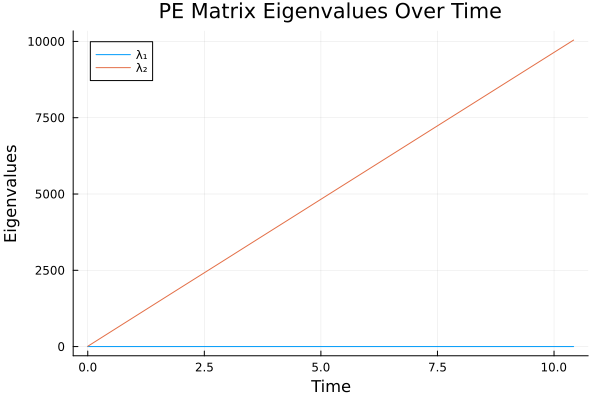

In [618]:
# Calculate persistence of excitation integral
PE_matrix = zeros(n_θ, n_θ)
PE_cumulative = zeros(length(t_vec), n_θ)
PE_running = zeros(n_θ, n_θ)

# Calculate PE matrix and track cumulative eigenvalues
for (j, t) in enumerate(t_vec)
    x = sol(t)[1:n_x]
    u = sol(t)[n_x+1:n_x+n_u]
    ϕ = G*Φ_θ(x, u)
    PE_running += ϕ'*ϕ * 0.1  # Multiply by time step for proper integration
    PE_cumulative[j, :] = eigvals(PE_running)
end

PE_matrix = PE_running  # Final integrated value

# Check if persistently exciting
eigenvalues = eigvals(PE_matrix)
is_PE = all(eigenvalues .> 1e-6)
println("Persistence of excitation check:")
println("PE integral eigenvalues: ", eigenvalues)
println("System is persistently exciting: ", is_PE)

# Plot the evolution of eigenvalues over time to visualize PE
plot(t_vec, PE_cumulative, xlabel="Time", ylabel="Eigenvalues",
     label=["λ₁" "λ₂" "λ₃"], title="PE Matrix Eigenvalues Over Time")

┌ Info: Saved animation to /home/dmrc/git/vtol-adaptive-control/vtol_animation.gif
└ @ Plots /home/dmrc/.julia/packages/Plots/uiCPf/src/animation.jl:156


Plots.AnimatedGif("/home/dmrc/git/vtol-adaptive-control/vtol_animation.gif")
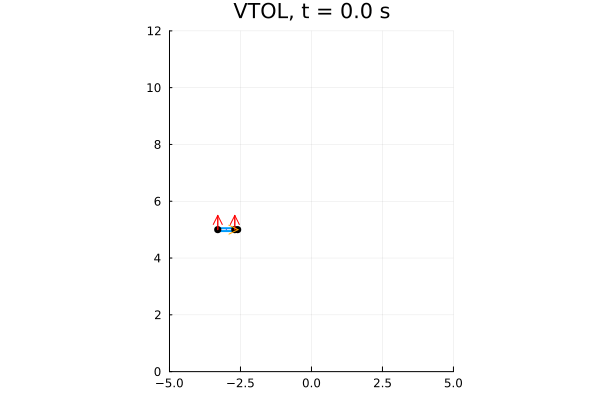

In [634]:
include("animation.jl")
animate_vtol(sol)

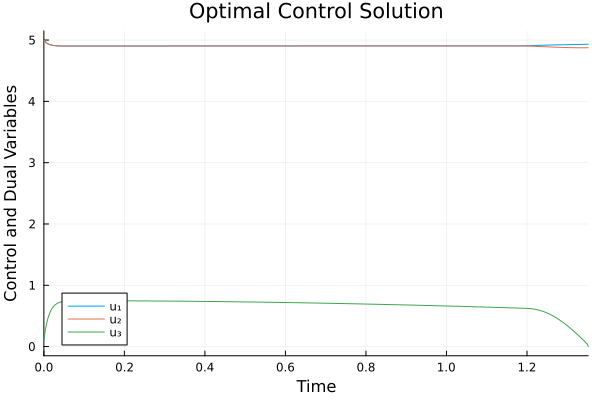

In [639]:
plot(sol, idxs= (0,n_x+1:n_x+n_u), xlabel="Time", ylabel="Control and Dual Variables",
     label=["u₁" "u₂" "u₃" ], title="Optimal Control Solution")

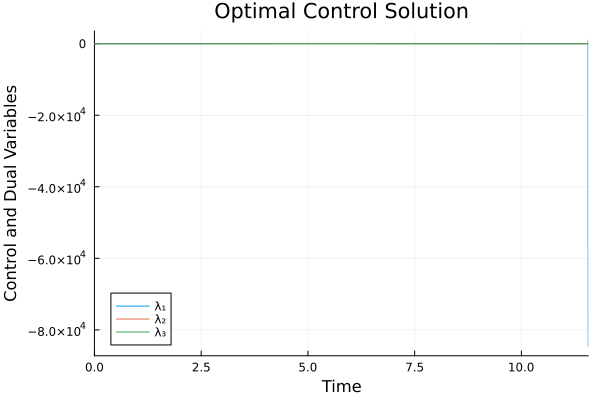

In [627]:
plot(sol, idxs= (0,n_x+n_u+1:n_x+n_u+n_λ), xlabel="Time", ylabel="Control and Dual Variables",
     label=["λ₁" "λ₂" "λ₃"], title="Optimal Control Solution")

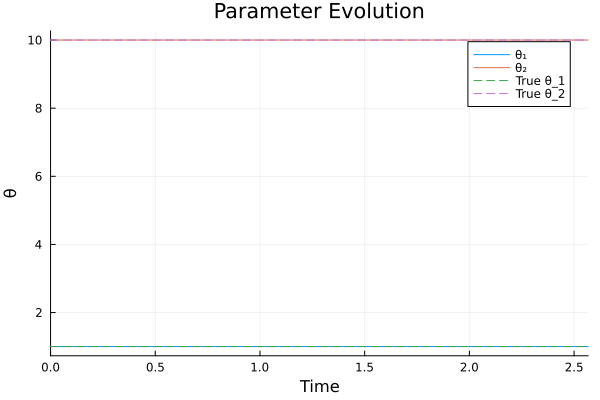

In [539]:
plot(sol, idxs=(0, n_x+n_u+n_λ+1:n_x+n_u+n_λ+n_θ), xlabel="Time", ylabel="θ",
     label=["θ₁" "θ₂"], title="Parameter Evolution")
for i in 1:n_θ
    plot!(t_vec, fill(θ_true[i], length(t_vec)), label="True θ_$i", linestyle=:dash)
end
plot!()

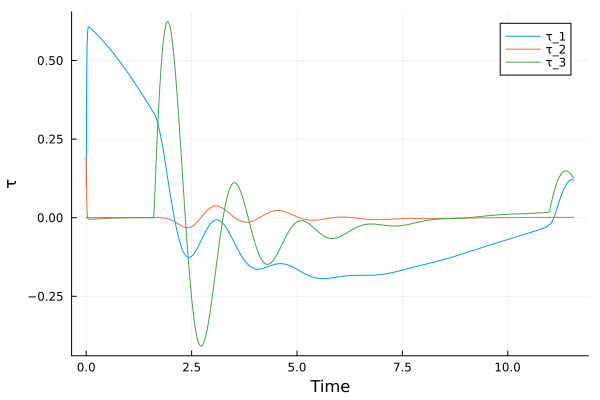

In [628]:
plot(t_vec, τ', label=["τ_1" "τ_2" "τ_3"], xlabel="Time", ylabel="τ")

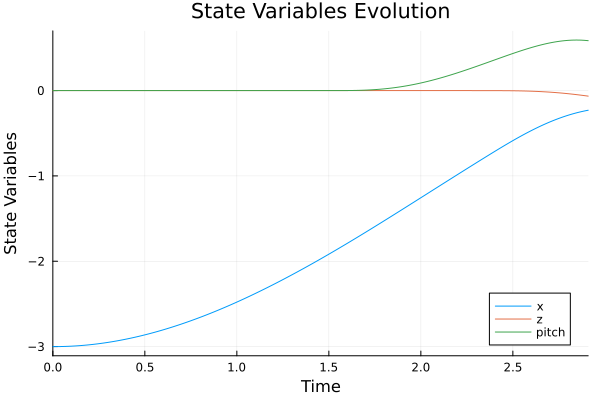

In [574]:
plot(sol, idxs= (0,[1,3,5]), xlabel="Time", ylabel="State Variables",
     label=["x" "z" "pitch"], title="State Variables Evolution")

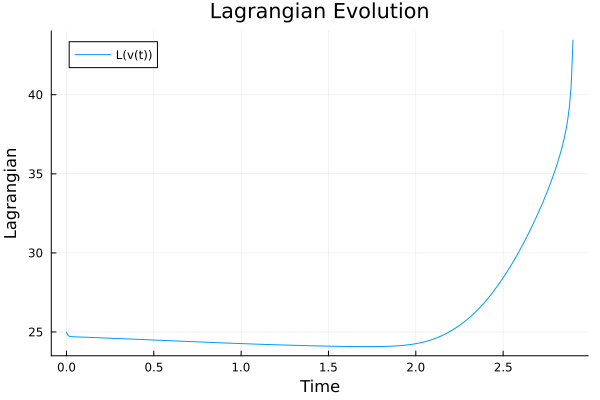

In [577]:
plot(t_vec, L_vec, xlabel="Time", ylabel="Lagrangian",
     title="Lagrangian Evolution", label="L(v(t))")

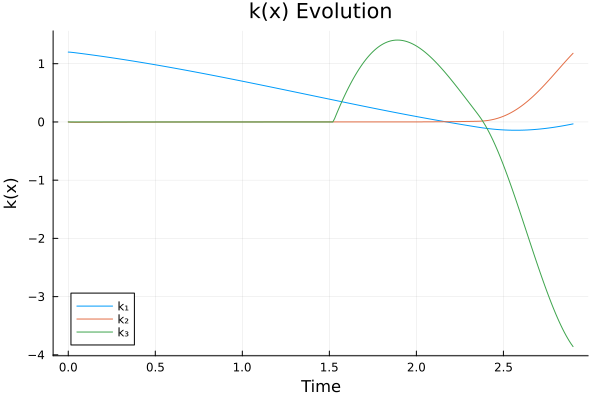

In [575]:
plot(t_vec, k_vec', label=["k₁" "k₂" "k₃"], xlabel="Time", ylabel="k(x)",
     title="k(x) Evolution")

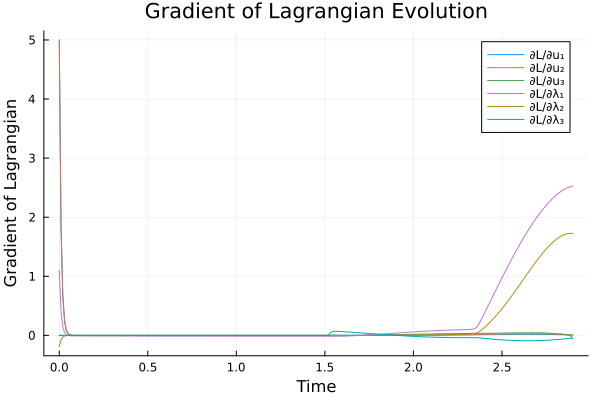

In [576]:
plot(t_vec, FOO_vec', label=["∂L/∂u₁" "∂L/∂u₂" "∂L/∂u₃" "∂L/∂λ₁" "∂L/∂λ₂" "∂L/∂λ₃"],
     xlabel="Time", ylabel="Gradient of Lagrangian",
     title="Gradient of Lagrangian Evolution")